In [2]:
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

17.124157770969063 6.721796755266026


/Users/lukezhu/miniconda3/envs/dbh_paper/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


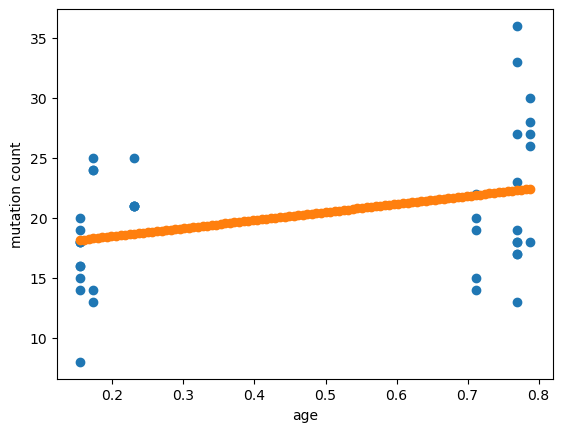

In [8]:
def load_lindsay_mouse_data():
    filename = "./data/lindsay_mouse_mutation_counts.txt"
    col_header = ["mouse_id", "count", "age_week"]
    df = pd.read_csv(filename, sep=" ", header=None, names=col_header, usecols=[0, 5, 8], index_col=[0])
    df["age_year"] = df["age_week"] / 52
    return df

def plot_mutation_data(df):
    # first column mutation count, second column age
    [intercept, slope, fitted_values] = perform_poisson_regression(df)
    fig, ax = plt.subplots(1, 1)
    ax.scatter(df["age_year"], df["count"])
    xmin, xmax = np.min(df["age_year"]), np.max(df["age_year"])
    x = np.linspace(xmin, xmax, 100)
    y_predict = intercept + slope * x
    ax.scatter(x, y_predict)
    # ax.scatter(df["age_year"], fitted_values)
    # ax.axline((0, intercept), slope=slope)
    ax.set_xlabel("age")
    ax.set_ylabel("mutation count")

def perform_poisson_regression(df):
    expr = "count ~ age_year"
    y, X = dmatrices(expr, df, return_type="dataframe")
    result = sm.GLM(y, X, family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
    # result = sm.OLS(y, X).fit()
    intercept, slope = result.params.Intercept, result.params.age_year
    print(intercept, slope)
    # print(results.coef, results.stderr)

    fitted_values = result.fittedvalues
    # mutation count ~ time
    # y = data[]
    # sm.GLM(
    #     data[:,0], 
    #     offset=,
    #     family=sm.families.Poisson())
    return intercept, slope, fitted_values
mouse_df = load_lindsay_mouse_data()
plot_mutation_data(mouse_df)
